# IBM AI Workflow Specialization Capstone #

## Case Study (Part 2) ##

Time-series analysis is a subject area that has many varied methods and a great potential for customized solutions.
We cannot cover the breadth and depth of this important area of data science in a single case study. We do 
however want to use this as a learning opportunity if time-series analysis is new to you.  For those of you who are seasoned 
practitioners in this area, it may be a useful time to hone your skills or try out a more advanced technique like 
Gaussian processes.  The reference materials for more advanced approaches to time-series analysis will occur in their own section
below. If this is your first encounter with time-series data we suggest that that you begin with the supervised learning
approach before trying out the other possible methods. 

### Various modelling approaches ###

Ideally, I would like to try out at least 2 or 3 different modelling approaches to time-series data. Since I am relatively new to time-series analysis, applying a basic model like those available in the statsmodels package might be a good starting point. However, I am well versed in the domains of Bayesian modelling and would like to apply those methods to this data as well. 

Therefore, the approaches I will start out with to identify and model the business opportunity are:

1. Basic Approaches
    i. AutoReg

    i. ARIMAX

    ii. SARIMAX
    
    iii. Seasonal ARIMAX
2. Bayesian Methods for time series

### Loading the data ###

In [1]:
import pandas as pd
import numpy as np
from load_data import load_data
from clean_data import clean_data
from prep_data import *
from sklearn.metrics import mean_squared_error

In [17]:
CSV_PATH = "time_series.csv"
DATA_DIR = "cs-train"
df = load_data(DATA_DIR)
df = clean_data(df)
merged_df = prepare_data(df)

We can also save the merged_df to a csv so that we only have to run the processing code once.

In [18]:
merged_df.to_csv(CSV_PATH)

In [19]:
df = pd.read_csv(CSV_PATH)
df.drop(df.columns[0], axis=1, inplace=True)
print(df.head())

         Date  Total Revenue  Total Unique invoices  Total Invoice Items  \
0  2017-11-28       14450.54                    166                 3223   
1  2017-11-29       13411.96                    133                 3277   
2  2017-11-30       13290.25                    150                 3002   
3  2017-12-01        9687.28                    107                 2559   
4  2017-12-02        1443.26                     32                  402   

   # Of Unique Content Streamed  Average items per invoice  
0                          1345                  19.415663  
1                          1397                  24.639098  
2                          1335                  20.013333  
3                          1256                  23.915888  
4                           287                  12.562500  


### Basic time-series modelling ###

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

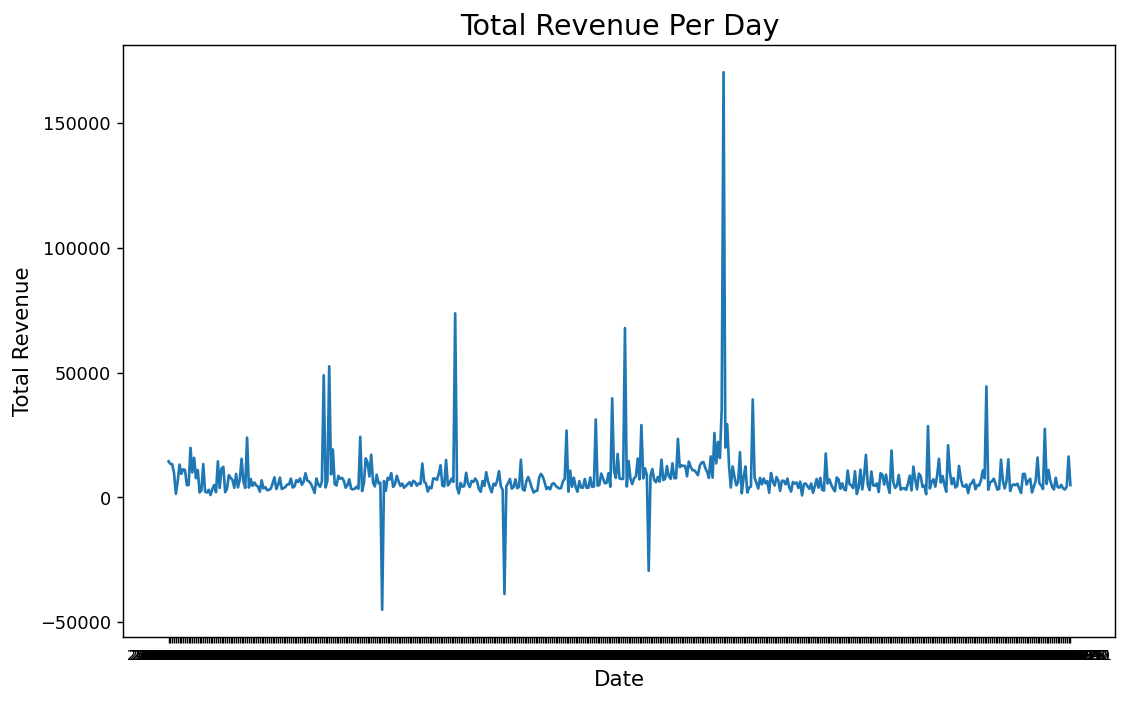

In [21]:
fig = plt.figure(dpi=128, figsize=(10,6))
plt.plot(df["Date"], df["Total Revenue"])
plt.title("Total Revenue Per Day", fontdict={"fontsize": 16})
plt.xlabel("Date", fontdict={"fontsize": 12})
plt.ylabel("Total Revenue", fontdict={"fontsize": 12})
plt.tick_params(axis='x', which='major', labelsize=8)
plt.show()

DatetimeIndex(['2017-11-28', '2017-11-29', '2017-11-30', '2017-12-01',
               '2017-12-02', '2017-12-03', '2017-12-04', '2017-12-05',
               '2017-12-06', '2017-12-07',
               ...
               '2019-07-21', '2019-07-22', '2019-07-23', '2019-07-24',
               '2019-07-25', '2019-07-26', '2019-07-28', '2019-07-29',
               '2019-07-30', '2019-07-31'],
              dtype='datetime64[ns]', name='Date', length=495, freq=None)


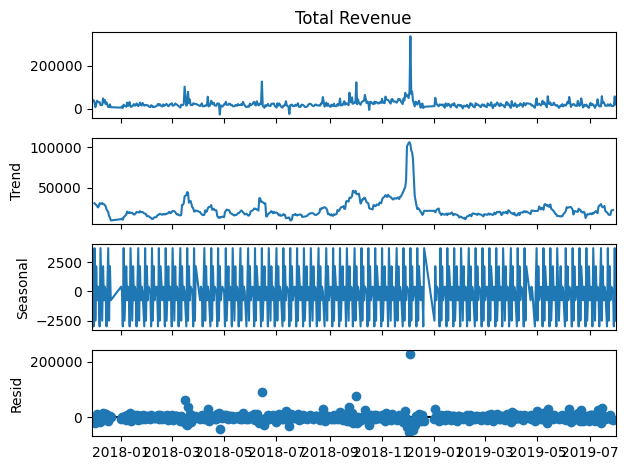

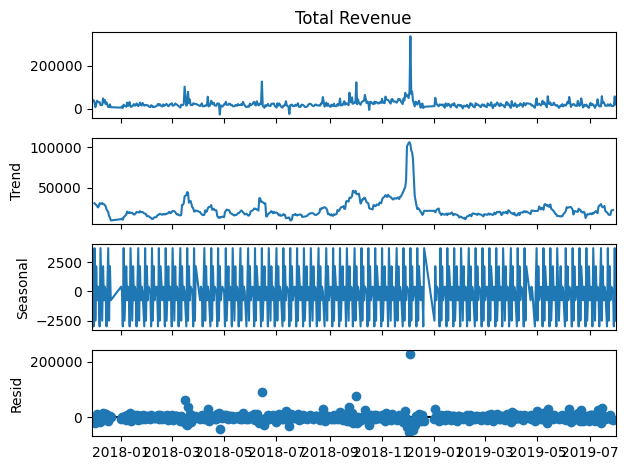

In [9]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# df.index = pd.to_datetime(df["Date"])
# print(df.index)
# decompose_data = seasonal_decompose(df["Total Revenue"],period=7, model="additive")
# decompose_data.plot()

### Split data into training and testing datasets ###

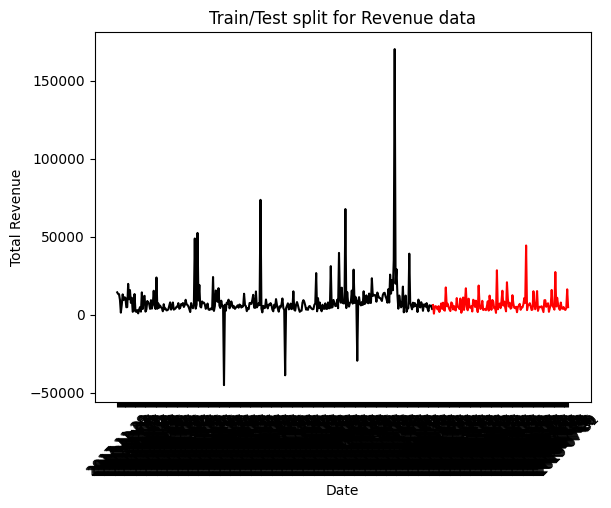

In [22]:
def train_test_split(df, split=0.7):
    n = int(len(df)*split)
    train = df[df.index < n]
    test = df[df.index >= n]
    train.index = train["Date"]
    test.index = test["Date"]
    return train, test

train, test = train_test_split(df)
plt.plot(train["Date"], train["Total Revenue"], color = "black")
plt.plot(test["Date"], test["Total Revenue"], color = "red")
plt.ylabel('Total Revenue')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Revenue data")
plt.show()

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

### Check whether series is stationary using Augmented Dickey Fuller Test ###

In [23]:
from statsmodels.tsa.stattools import adfuller

adfuller(df["Total Revenue"])

(-10.177556271997435,
 6.828860388337295e-18,
 2,
 492,
 {'1%': -3.4437112724287253,
  '5%': -2.8674324209387345,
  '10%': -2.569908433637385},
 10210.811940184856)

Since the p-value given by the Augmented Dickey Fuller Test on the data is significant less than 0.05, we reject the null hypothesis and instead accept the hypothesis that the data is stationary. 

Since the data is stationary, we can now move onto the next stage of the process, which is looking at the ACF and PACF curves.

### Autocorrelation Function (ACF) ###

For any time series analysis, it's important to find the right lag


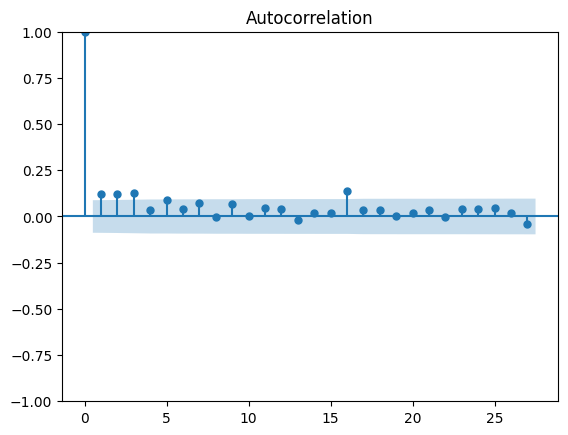

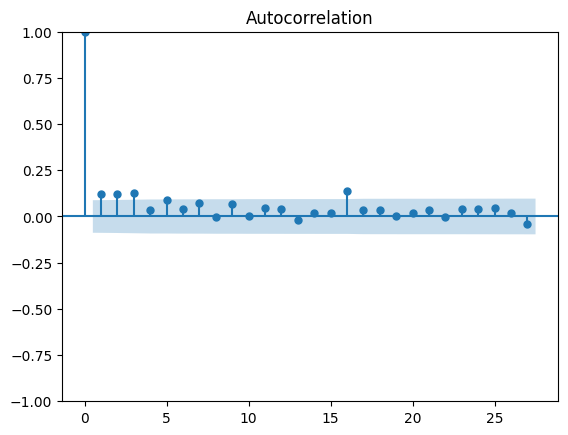

In [24]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df["Total Revenue"])

The quality of the correlation isn't very strong, but it gives a better sense of what to use for the hyperparameters for ARIMA. Ideally should use the time series predictions for lags 1, 2 and 3.

### Partial Autocorrelation Function (PACF) ###

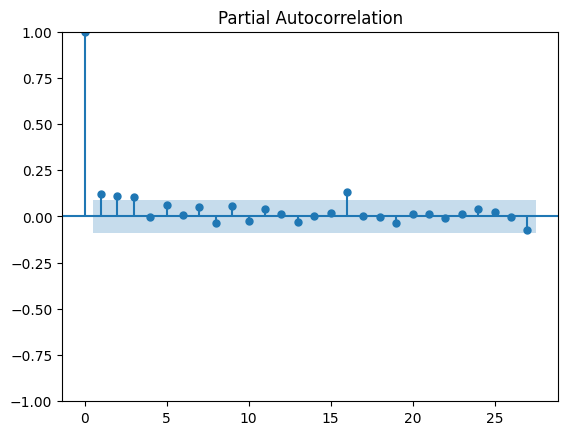

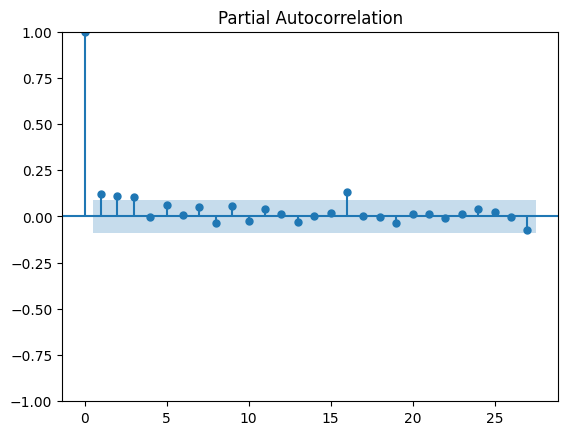

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df["Total Revenue"])

### AutoReg model ###

An Auto-Regressive model seems like a good first test to see whether or not a basic model will be enough to accurately measure the time series data. The error metric I use in this case is Mean Squared Root Error (MSRE). 

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AutoReg

def show_pacf(data):
    plot_pacf(data)

def show_acf(data):
    plot_acf(data)

def extract_acf_data(data, threshold=0.25, nlags=25):
    stats = acf(data, nlags=nlags)
    return np.argwhere(stats>=threshold)

def extract_pacf_data(data, threshold=0.25, nlags=25):
    stats = pacf(data, nlags=nlags)
    return np.argwhere(stats>=threshold)

def find_best_autoreg_model(train, test, values, error_function):
    best_model = None
    best_error = np.inf
    best_lags = 0
    for value in values:
        ar_model = AutoReg(train["Total Revenue"], lags=value).fit()
        pred = ar_model.predict(start=len(train)+1, end=len(train)+len(test), dynamic=False)
        error = error_function(test["Total Revenue"], pred)
        if error < best_error:
            best_model = ar_model
            best_error = error
            best_lags = value
    return best_model, best_error, best_lags

[ 0  1  2  3 16]
16
31040832.740310233


c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, Datetime

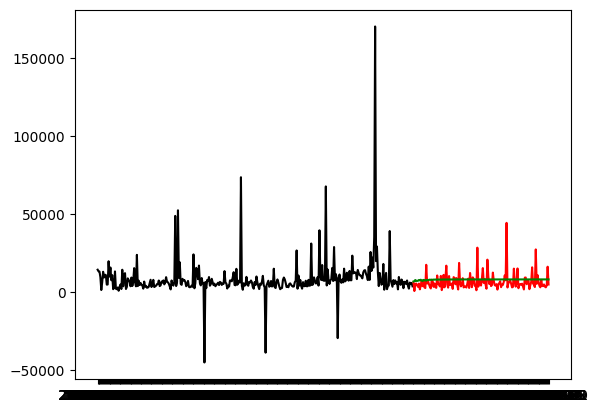

In [28]:
testing = extract_acf_data(df["Total Revenue"], threshold=0.1, nlags=40)
testing = np.reshape(testing, (testing.shape[0],))
print(testing)
best_model, best_error, best_lags = find_best_autoreg_model(train, test, testing, mean_squared_error)
print(best_lags)
print(best_error)

pred = best_model.predict(start=len(train)+1, end=len(df), dynamic=False)
plt.plot(train.index, train["Total Revenue"], color = "black")
plt.plot(test.index, test["Total Revenue"], color = "red")
plt.plot(test.index, pred, color='green', label = 'Predictions')

The baseline model is an AR model with nlags=18 and a MSRE of 113713613.62138447.

### ARIMA ###
For ARIMA, there are three hyperparameters in the order that can be tuned:
Lagging, Differencing and White Noise.

Since we know that the revenue data is stationary, we can simply set the differencing hyperparameter for ARIMA to 0. 

We can tune these using an Sklearn grid search, and find the one that minimizes the RMSE. 

### Building ARIMA from scratch ###

With the custom AR code, p=6 achieves an RMSE of 111951511.7695854\
With p=12, achieves an RMSE of 111383511.19442585\
p=20, RMSE=109294707.2808792\
p=21, RMSE=109159848.17797965\
p=23, RMSE=109155569.81390032\
p=24, RMSE=107300607.71913774\
p=28, RMSE=106450316.0581218\
p=30, RMSE=106117890.74757954\

So p=30 might be the best that we're going to get with an underlying Linear Regression. 

Note that the AR model is actually starting to match the shape of the overall distribution better.

### Moving average model ###

In [46]:
from sklearn.pipeline import Pipeline
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [43]:
def predict_with_time_series(model):
    y_pred = model.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05)

    y_pred_df["Predictions"] = model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = test.index
    y_pred_out = y_pred_df["Predictions"]
    return y_pred_out

In [44]:
def build_time_series_pipeline(model_type, order, data):
    pipe = Pipeline([("time", model_type(data, order = order).fit()), ("predict", predict_with_time_series)])
    y_pred_out = pipe["predict"](pipe["time"])
    return pipe, y_pred_out

In [50]:
def custom_grid_search(model, parameters, data, target_metric):
    best_model = None
    best_error = float("INF")
    best_order = None
    for order in parameters["order"]:
        try:
            pipeline, predictions = build_time_series_pipeline(model, order, data)
            error = target_metric(test["Total Revenue"].values, predictions)
            if error < best_error:
                best_error = error
                best_model = pipeline
                best_order = order
        except:
            continue
    return best_model, best_error, best_order

Date
2017-11-28    14450.54
2017-11-29    13411.96
2017-11-30    13290.25
2017-12-01     9687.28
2017-12-02     1443.26
                ...   
2019-01-27     2321.72
2019-01-28     6190.13
2019-01-29     5561.46
2019-01-30     5978.85
2019-01-31     3817.55
Name: Total Revenue, Length: 346, dtype: float64


c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the 

(16, 0, 4)
31465877.440587543
Date
2019-02-01    5847.220820
2019-02-03    8332.350443
2019-02-04    8926.316759
2019-02-05    7182.413573
2019-02-06    5746.190695
                 ...     
2019-07-26    8260.728090
2019-07-28    8254.667103
2019-07-29    8241.070940
2019-07-30    8249.535461
2019-07-31    8256.640886
Name: Predictions, Length: 149, dtype: float64


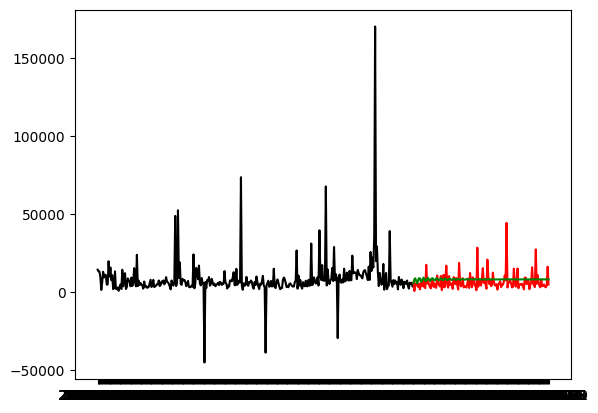

In [51]:
#Grid search
from sklearn.metrics import mean_squared_error
y = train["Total Revenue"]
parameters = {"order": [(i, j, k) for i in range(16,17) for j in range(0,1) for k in range(0,10)]}
ARMAmodel = SARIMAX
print(y)
best_pipe, best_error, best_order = custom_grid_search(ARMAmodel, parameters, y, mean_squared_error)
print(best_order)
print(best_error)
y_pred_out = best_pipe["predict"](best_pipe["time"])
print(y_pred_out)
plt.plot(train.index, train["Total Revenue"], color = "black")
plt.plot(test.index, test["Total Revenue"], color = "red")
plt.plot(test.index, y_pred_out, color='green', label = 'Predictions')

c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results w

                               SARIMAX Results                                
Dep. Variable:          Total Revenue   No. Observations:                  346
Model:               SARIMAX(6, 2, 4)   Log Likelihood               -3925.985
Date:                Fri, 27 Oct 2023   AIC                           7873.970
Time:                        15:52:31   BIC                           7916.217
Sample:                             0   HQIC                          7890.797
                                - 346                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6009      0.072    -22.304      0.000      -1.742      -1.460
ar.L2         -0.5049      0.160     -3.159      0.002      -0.818      -0.192
ar.L3          0.5039      0.206      2.444      0.0

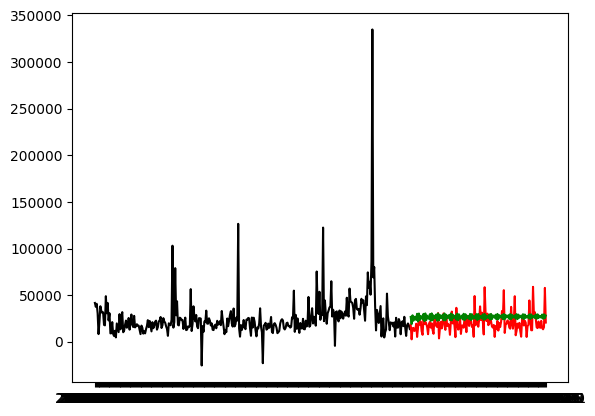

In [13]:
y = train["Total Revenue"]
ARMAmodel = SARIMAX(y, order = (6, 2, 4))
ARMAmodel = ARMAmodel.fit()
print(ARMAmodel.summary())
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
print(y_pred_df)
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_out = y_pred_df["Predictions"]
plt.plot(train.index, train["Total Revenue"], color = "black")
plt.plot(test.index, test["Total Revenue"], color = "red")
plt.plot(y_pred_df.index, y_pred_out, color='green', label = 'Predictions')
arma_rmse = np.sqrt(mean_squared_error(test["Total Revenue"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [39]:
import numpy as np
from sklearn.metrics import mean_squared_error


RMSE:  10104.498589432764


### ARIMA model ###

c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is ava

(3, 1, 6)
10070.353034583459


c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the n

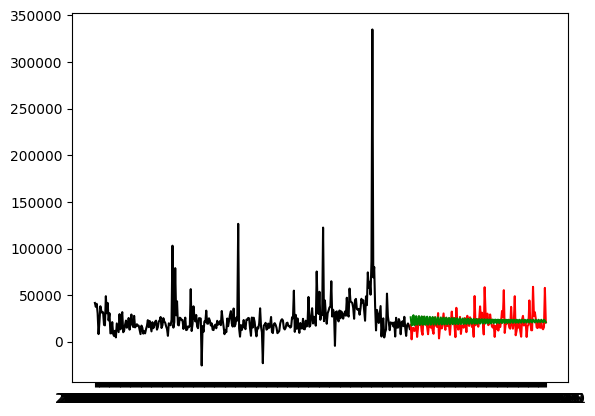

In [14]:
parameters = {"order": [(i, j, k) for i in range(1,10) for j in range(1,10) for k in range(1,10)]}
ARIMAmodel = ARIMA
best_pipe, best_error, best_order = custom_grid_search(ARIMAmodel, parameters, y, mean_squared_error)
print(best_order)
print(best_error)
y_pred_out = best_pipe["predict"](best_pipe["time"])
plt.plot(train.index, train["Total Revenue"], color = "black")
plt.plot(test.index, test["Total Revenue"], color = "red")
plt.plot(test.index, y_pred_out, color='green', label = 'Predictions')

### Seasonal ARIMA ###

c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results w

Date
2019-02-01      3332.965805
2019-02-03     -9517.413462
2019-02-04     25168.154113
2019-02-05     24246.374512
2019-02-06      5336.735411
                  ...      
2019-07-26   -131271.066311
2019-07-28   -139110.285110
2019-07-29   -122237.092168
2019-07-30   -134542.710914
2019-07-31   -116771.316448
Name: Predictions, Length: 149, dtype: float64


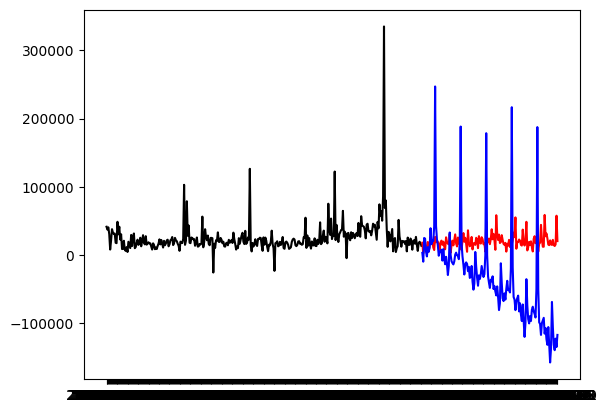

In [24]:
parameters = {"order": [(i, j, k) for i in range(1,6) for j in range(1,6) for k in range(1,6)]}

SARIMAXmodel = SARIMAX(y, order = (3,1,6), seasonal_order=(2,2,2,28))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]
print(y_pred_out)
plt.plot(train.index, train["Total Revenue"], color = "black")
plt.plot(test.index, test["Total Revenue"], color = "red")
plt.plot(y_pred_out.index, y_pred_out, color='Blue', label = 'SARIMA Predictions')

In [23]:
arma_rmse = np.sqrt(mean_squared_error(test["Total Revenue"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  83354.661860345


### Chart of hyperparameters ###
Lagging     Differencing        White Noise         RMSE
2           2                   2                   10948
3           2                   2                   10365
4           2                   2                   10711
5           2                   2                   11460
2           2                   3                   10978
2           2                   4                   11058

### Prophet ###

I'll try Prophet so see if I can reproduce the same results as the other person's data. 

In [24]:
!python -m pip install prophet

^C


Importing plotly failed. Interactive plots will not work.
16:06:48 - cmdstanpy - INFO - Chain [1] start processing
16:06:49 - cmdstanpy - INFO - Chain [1] done processing


24801769.007212672


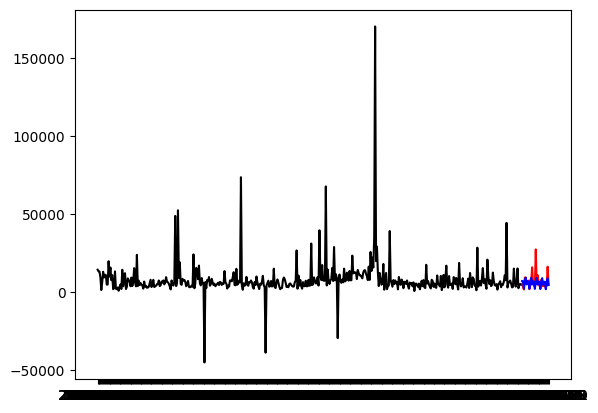

In [55]:
from prophet import Prophet
df = pd.read_csv(CSV_PATH)
df.rename(columns={'Date':'ds', 'Total Revenue': 'y'}, inplace=True)
df_train = df[:-30]
df_test = df[-30:]
    
m = Prophet(weekly_seasonality=True)  
m.fit(df_train)

y_pred = m.predict(df_test)
error = mean_squared_error(df_test.y, y_pred.yhat)
print(error)
plt.plot(df_train.ds, df_train.y, color = "black")
plt.plot(df_test.ds, df_test.y, color = "red")
plt.plot(df_test.ds, y_pred.yhat, color='Blue', label = 'SARIMA Predictions')
# ts_plot_pred(df.ds.values, df.y.values,df[-30:].ds.values, y_pred[key][-30:].yhat.values, figx=16,figy=8, title="revenue over time ({})".format(key))